In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import pearsonr

import seaborn as sns
import os
import scipy
import scipy.io

In [2]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [3]:
a = scipy.io.loadmat("../data/zeisel/zeisel_data.mat")
data= a['zeisel_data'].T
N,d=data.shape

#load labels (first level of the hierarchy) from file
a = scipy.io.loadmat("../data/zeisel/zeisel_labels1.mat")
l_aux = a['zeisel_labels1']
l_0=[l_aux[i][0] for i in range(l_aux.shape[0])]
#load labels (second level of the hierarchy) from file
a = scipy.io.loadmat("../data/zeisel/zeisel_labels2.mat")
l_aux = a['zeisel_labels2']
l_1=[l_aux[i][0] for i in range(l_aux.shape[0])]
#construct an array with hierarchy labels
labels=np.array([l_0, l_1])

# load names from file 
a = scipy.io.loadmat("../data/zeisel/zeisel_names.mat")
names0=np.array([a['zeisel_names'][i][0][0] for i in range(N)])
names1=[a['zeisel_names'][i][1][0] for i in range(N)]

np.random.seed(100)
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_labels = names0[slices[:upto]]
test_labels = names0[slices[upto:]]


scaler = StandardScaler(with_mean=False)
#scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [4]:
N = 10000
z_size = 100

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 32
lr = 0.000001
b1 = 0.9
b2 = 0.999

global_t = 4
k = 50

In [5]:
def train_model(train_data, model):
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=lr, 
                                 betas = (b1,b2))
    
    
    for epoch in range(1, n_epochs+1):
        train(train_data, 
              model, 
              optimizer, 
              epoch, 
              batch_size)
        model.t = max(0.001, model.t * 0.99)

        
    return model

def save_model(base_path, model):
    # make directory
    if not os.path.exists(os.path.dirname(base_path)):
        try:
            os.makedirs(os.path.dirname(base_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise Exception("COULD NOT MAKE PATH")
    with open(base_path, 'wb') as PATH:
        torch.save(model.state_dict(), PATH)
        
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a = 0.01)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [6]:
def top_logits_gumbel_globalgate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_GlobalGate)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_runningstate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_RunningState)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)

        inds = torch.argsort(subset_indices.sum(dim = 0), descending = True)[:model.k]
        all_logits = torch.nn.functional.one_hot(inds, num_classes = data.shape[1]).sum(dim = 0)
        
        
        
        
    return all_logits, all_subsets

In [7]:
model = VAE_Gumbel_RunningState(train_data.shape[1], 250, 100, k = k, t = global_t, alpha = 0.9, bias = False)


In [8]:
model

VAE_Gumbel_RunningState(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=250, out_features=100, bias=False)
  (enc_logvar): Linear(in_features=250, out_features=100, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=250, out_features=4000, bias=False)
    (3): Sigmoid()
  )
  (weight_creator): Sequential(
    (0): Linear(in_features=4000, out_features=250, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=250, out_features=4000, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

In [9]:
model.to(device)
model.apply(weights_init)
train_model(train_data, model)
model.set_burned_in()

Train Epoch: 1 [0/2404 (0%)]	Loss: 5784.181152
Train Epoch: 1 [640/2404 (27%)]	Loss: 6960.857422
Train Epoch: 1 [1280/2404 (53%)]	Loss: 5597.416992
Train Epoch: 1 [1920/2404 (80%)]	Loss: 6674.490723
====> Epoch: 1 Average loss: 5998.6989
Train Epoch: 2 [0/2404 (0%)]	Loss: 5331.142578
Train Epoch: 2 [640/2404 (27%)]	Loss: 5699.926270
Train Epoch: 2 [1280/2404 (53%)]	Loss: 5074.676270
Train Epoch: 2 [1920/2404 (80%)]	Loss: 6377.464844
====> Epoch: 2 Average loss: 5991.2782
Train Epoch: 3 [0/2404 (0%)]	Loss: 6232.830566
Train Epoch: 3 [640/2404 (27%)]	Loss: 5374.739746
Train Epoch: 3 [1280/2404 (53%)]	Loss: 7138.301758
Train Epoch: 3 [1920/2404 (80%)]	Loss: 6933.931152
====> Epoch: 3 Average loss: 5980.2011
Train Epoch: 4 [0/2404 (0%)]	Loss: 5317.074707
Train Epoch: 4 [640/2404 (27%)]	Loss: 5598.497070
Train Epoch: 4 [1280/2404 (53%)]	Loss: 5805.512207
Train Epoch: 4 [1920/2404 (80%)]	Loss: 6780.386719
====> Epoch: 4 Average loss: 5972.6632
Train Epoch: 5 [0/2404 (0%)]	Loss: 5636.502930
T

Train Epoch: 35 [640/2404 (27%)]	Loss: 6258.601562
Train Epoch: 35 [1280/2404 (53%)]	Loss: 5586.973633
Train Epoch: 35 [1920/2404 (80%)]	Loss: 5461.157715
====> Epoch: 35 Average loss: 5672.0820
Train Epoch: 36 [0/2404 (0%)]	Loss: 6565.317383
Train Epoch: 36 [640/2404 (27%)]	Loss: 6044.005371
Train Epoch: 36 [1280/2404 (53%)]	Loss: 5528.113770
Train Epoch: 36 [1920/2404 (80%)]	Loss: 4972.492188
====> Epoch: 36 Average loss: 5660.2197
Train Epoch: 37 [0/2404 (0%)]	Loss: 5062.073242
Train Epoch: 37 [640/2404 (27%)]	Loss: 4831.243652
Train Epoch: 37 [1280/2404 (53%)]	Loss: 6013.792969
Train Epoch: 37 [1920/2404 (80%)]	Loss: 4849.399902
====> Epoch: 37 Average loss: 5649.4195
Train Epoch: 38 [0/2404 (0%)]	Loss: 5145.281250
Train Epoch: 38 [640/2404 (27%)]	Loss: 5274.221680
Train Epoch: 38 [1280/2404 (53%)]	Loss: 6163.535645
Train Epoch: 38 [1920/2404 (80%)]	Loss: 6437.292480
====> Epoch: 38 Average loss: 5639.3198
Train Epoch: 39 [0/2404 (0%)]	Loss: 5406.681152
Train Epoch: 39 [640/2404 (2

Train Epoch: 69 [640/2404 (27%)]	Loss: 4830.666016
Train Epoch: 69 [1280/2404 (53%)]	Loss: 4415.984863
Train Epoch: 69 [1920/2404 (80%)]	Loss: 6112.386719
====> Epoch: 69 Average loss: 5268.2040
Train Epoch: 70 [0/2404 (0%)]	Loss: 4752.159180
Train Epoch: 70 [640/2404 (27%)]	Loss: 6399.033203
Train Epoch: 70 [1280/2404 (53%)]	Loss: 5365.450195
Train Epoch: 70 [1920/2404 (80%)]	Loss: 5186.047363
====> Epoch: 70 Average loss: 5255.2984
Train Epoch: 71 [0/2404 (0%)]	Loss: 5045.810059
Train Epoch: 71 [640/2404 (27%)]	Loss: 5114.818848
Train Epoch: 71 [1280/2404 (53%)]	Loss: 4580.481445
Train Epoch: 71 [1920/2404 (80%)]	Loss: 4932.758789
====> Epoch: 71 Average loss: 5242.6933
Train Epoch: 72 [0/2404 (0%)]	Loss: 5011.851074
Train Epoch: 72 [640/2404 (27%)]	Loss: 5166.993164
Train Epoch: 72 [1280/2404 (53%)]	Loss: 5592.337402
Train Epoch: 72 [1920/2404 (80%)]	Loss: 5061.289062
====> Epoch: 72 Average loss: 5230.7461
Train Epoch: 73 [0/2404 (0%)]	Loss: 5281.733887
Train Epoch: 73 [640/2404 (2

Train Epoch: 103 [640/2404 (27%)]	Loss: 5122.028320
Train Epoch: 103 [1280/2404 (53%)]	Loss: 4975.995605
Train Epoch: 103 [1920/2404 (80%)]	Loss: 4268.453613
====> Epoch: 103 Average loss: 4891.1270
Train Epoch: 104 [0/2404 (0%)]	Loss: 4850.174316
Train Epoch: 104 [640/2404 (27%)]	Loss: 4161.328613
Train Epoch: 104 [1280/2404 (53%)]	Loss: 4975.683594
Train Epoch: 104 [1920/2404 (80%)]	Loss: 4614.087402
====> Epoch: 104 Average loss: 4881.0320
Train Epoch: 105 [0/2404 (0%)]	Loss: 4792.391602
Train Epoch: 105 [640/2404 (27%)]	Loss: 4207.636230
Train Epoch: 105 [1280/2404 (53%)]	Loss: 5515.912598
Train Epoch: 105 [1920/2404 (80%)]	Loss: 4853.799805
====> Epoch: 105 Average loss: 4872.4717
Train Epoch: 106 [0/2404 (0%)]	Loss: 5159.187988
Train Epoch: 106 [640/2404 (27%)]	Loss: 5029.573730
Train Epoch: 106 [1280/2404 (53%)]	Loss: 5089.749512
Train Epoch: 106 [1920/2404 (80%)]	Loss: 4405.333008
====> Epoch: 106 Average loss: 4862.9808
Train Epoch: 107 [0/2404 (0%)]	Loss: 5839.124023
Train Ep

Train Epoch: 136 [1280/2404 (53%)]	Loss: 4100.833984
Train Epoch: 136 [1920/2404 (80%)]	Loss: 4266.261230
====> Epoch: 136 Average loss: 4630.5998
Train Epoch: 137 [0/2404 (0%)]	Loss: 3883.368652
Train Epoch: 137 [640/2404 (27%)]	Loss: 5183.678711
Train Epoch: 137 [1280/2404 (53%)]	Loss: 4665.073730
Train Epoch: 137 [1920/2404 (80%)]	Loss: 4888.922363
====> Epoch: 137 Average loss: 4624.4181
Train Epoch: 138 [0/2404 (0%)]	Loss: 4551.059082
Train Epoch: 138 [640/2404 (27%)]	Loss: 5217.999512
Train Epoch: 138 [1280/2404 (53%)]	Loss: 4271.952637
Train Epoch: 138 [1920/2404 (80%)]	Loss: 3751.408447
====> Epoch: 138 Average loss: 4616.9788
Train Epoch: 139 [0/2404 (0%)]	Loss: 5411.442383
Train Epoch: 139 [640/2404 (27%)]	Loss: 5508.467285
Train Epoch: 139 [1280/2404 (53%)]	Loss: 4652.537598
Train Epoch: 139 [1920/2404 (80%)]	Loss: 4475.735840
====> Epoch: 139 Average loss: 4612.1524
Train Epoch: 140 [0/2404 (0%)]	Loss: 4948.509766
Train Epoch: 140 [640/2404 (27%)]	Loss: 4557.491699
Train Ep

Train Epoch: 169 [1920/2404 (80%)]	Loss: 4139.497070
====> Epoch: 169 Average loss: 4458.6822
Train Epoch: 170 [0/2404 (0%)]	Loss: 4259.802246
Train Epoch: 170 [640/2404 (27%)]	Loss: 5679.277344
Train Epoch: 170 [1280/2404 (53%)]	Loss: 5037.582031
Train Epoch: 170 [1920/2404 (80%)]	Loss: 4074.059082
====> Epoch: 170 Average loss: 4455.2211
Train Epoch: 171 [0/2404 (0%)]	Loss: 4271.175293
Train Epoch: 171 [640/2404 (27%)]	Loss: 4912.579102
Train Epoch: 171 [1280/2404 (53%)]	Loss: 3802.378662
Train Epoch: 171 [1920/2404 (80%)]	Loss: 4476.024902
====> Epoch: 171 Average loss: 4450.8824
Train Epoch: 172 [0/2404 (0%)]	Loss: 4410.447266
Train Epoch: 172 [640/2404 (27%)]	Loss: 4638.400391
Train Epoch: 172 [1280/2404 (53%)]	Loss: 4645.902344
Train Epoch: 172 [1920/2404 (80%)]	Loss: 3753.731201
====> Epoch: 172 Average loss: 4448.0365
Train Epoch: 173 [0/2404 (0%)]	Loss: 3913.911133
Train Epoch: 173 [640/2404 (27%)]	Loss: 4633.314453
Train Epoch: 173 [1280/2404 (53%)]	Loss: 4158.870117
Train Ep

====> Epoch: 202 Average loss: 4353.7231
Train Epoch: 203 [0/2404 (0%)]	Loss: 4357.699707
Train Epoch: 203 [640/2404 (27%)]	Loss: 5071.930664
Train Epoch: 203 [1280/2404 (53%)]	Loss: 3994.137451
Train Epoch: 203 [1920/2404 (80%)]	Loss: 4779.820312
====> Epoch: 203 Average loss: 4352.4710
Train Epoch: 204 [0/2404 (0%)]	Loss: 4635.554199
Train Epoch: 204 [640/2404 (27%)]	Loss: 5094.062988
Train Epoch: 204 [1280/2404 (53%)]	Loss: 4392.379883
Train Epoch: 204 [1920/2404 (80%)]	Loss: 4582.137207
====> Epoch: 204 Average loss: 4349.7914
Train Epoch: 205 [0/2404 (0%)]	Loss: 4510.838379
Train Epoch: 205 [640/2404 (27%)]	Loss: 4204.321289
Train Epoch: 205 [1280/2404 (53%)]	Loss: 4927.327637
Train Epoch: 205 [1920/2404 (80%)]	Loss: 4010.367920
====> Epoch: 205 Average loss: 4347.3973
Train Epoch: 206 [0/2404 (0%)]	Loss: 3929.447266
Train Epoch: 206 [640/2404 (27%)]	Loss: 3945.768555
Train Epoch: 206 [1280/2404 (53%)]	Loss: 4688.693359
Train Epoch: 206 [1920/2404 (80%)]	Loss: 4744.248047
====> Ep

Train Epoch: 236 [640/2404 (27%)]	Loss: 4011.116699
Train Epoch: 236 [1280/2404 (53%)]	Loss: 3704.305420
Train Epoch: 236 [1920/2404 (80%)]	Loss: 3909.372070
====> Epoch: 236 Average loss: 4292.4926
Train Epoch: 237 [0/2404 (0%)]	Loss: 4156.616699
Train Epoch: 237 [640/2404 (27%)]	Loss: 4529.911621
Train Epoch: 237 [1280/2404 (53%)]	Loss: 4083.999512
Train Epoch: 237 [1920/2404 (80%)]	Loss: 4160.075195
====> Epoch: 237 Average loss: 4293.6868
Train Epoch: 238 [0/2404 (0%)]	Loss: 4098.560547
Train Epoch: 238 [640/2404 (27%)]	Loss: 4158.565430
Train Epoch: 238 [1280/2404 (53%)]	Loss: 4233.074219
Train Epoch: 238 [1920/2404 (80%)]	Loss: 3789.699951
====> Epoch: 238 Average loss: 4300.5950
Train Epoch: 239 [0/2404 (0%)]	Loss: 4060.273193
Train Epoch: 239 [640/2404 (27%)]	Loss: 3781.932129
Train Epoch: 239 [1280/2404 (53%)]	Loss: 4493.535156
Train Epoch: 239 [1920/2404 (80%)]	Loss: 4298.767090
====> Epoch: 239 Average loss: 4300.1543
Train Epoch: 240 [0/2404 (0%)]	Loss: 4888.959961
Train Ep

Train Epoch: 269 [1280/2404 (53%)]	Loss: 5052.572266
Train Epoch: 269 [1920/2404 (80%)]	Loss: 4728.384766
====> Epoch: 269 Average loss: 4305.0959
Train Epoch: 270 [0/2404 (0%)]	Loss: 3957.246582
Train Epoch: 270 [640/2404 (27%)]	Loss: 3956.638916
Train Epoch: 270 [1280/2404 (53%)]	Loss: 4948.245605
Train Epoch: 270 [1920/2404 (80%)]	Loss: 4307.544434
====> Epoch: 270 Average loss: 4301.7003
Train Epoch: 271 [0/2404 (0%)]	Loss: 4162.321289
Train Epoch: 271 [640/2404 (27%)]	Loss: 3912.615967
Train Epoch: 271 [1280/2404 (53%)]	Loss: 4307.803711
Train Epoch: 271 [1920/2404 (80%)]	Loss: 3923.158936
====> Epoch: 271 Average loss: 4299.1045
Train Epoch: 272 [0/2404 (0%)]	Loss: 4008.089844
Train Epoch: 272 [640/2404 (27%)]	Loss: 4339.912598
Train Epoch: 272 [1280/2404 (53%)]	Loss: 3930.120361
Train Epoch: 272 [1920/2404 (80%)]	Loss: 4412.477051
====> Epoch: 272 Average loss: 4294.1325
Train Epoch: 273 [0/2404 (0%)]	Loss: 3912.956299
Train Epoch: 273 [640/2404 (27%)]	Loss: 4457.609375
Train Ep

Train Epoch: 302 [1920/2404 (80%)]	Loss: 4369.736816
====> Epoch: 302 Average loss: 4269.9483
Train Epoch: 303 [0/2404 (0%)]	Loss: 3754.216553
Train Epoch: 303 [640/2404 (27%)]	Loss: 3869.202637
Train Epoch: 303 [1280/2404 (53%)]	Loss: 4775.763184
Train Epoch: 303 [1920/2404 (80%)]	Loss: 4055.208496
====> Epoch: 303 Average loss: 4269.2115
Train Epoch: 304 [0/2404 (0%)]	Loss: 4079.270020
Train Epoch: 304 [640/2404 (27%)]	Loss: 4150.433105
Train Epoch: 304 [1280/2404 (53%)]	Loss: 4088.085938
Train Epoch: 304 [1920/2404 (80%)]	Loss: 4310.378418
====> Epoch: 304 Average loss: 4271.0790
Train Epoch: 305 [0/2404 (0%)]	Loss: 4706.364746
Train Epoch: 305 [640/2404 (27%)]	Loss: 3976.194824
Train Epoch: 305 [1280/2404 (53%)]	Loss: 4140.975098
Train Epoch: 305 [1920/2404 (80%)]	Loss: 4136.253906
====> Epoch: 305 Average loss: 4268.0119
Train Epoch: 306 [0/2404 (0%)]	Loss: 3879.104492
Train Epoch: 306 [640/2404 (27%)]	Loss: 4143.068848
Train Epoch: 306 [1280/2404 (53%)]	Loss: 4068.180908
Train Ep

====> Epoch: 335 Average loss: 4242.8262
Train Epoch: 336 [0/2404 (0%)]	Loss: 4691.444824
Train Epoch: 336 [640/2404 (27%)]	Loss: 4280.632812
Train Epoch: 336 [1280/2404 (53%)]	Loss: 4177.873047
Train Epoch: 336 [1920/2404 (80%)]	Loss: 4736.050781
====> Epoch: 336 Average loss: 4241.0803
Train Epoch: 337 [0/2404 (0%)]	Loss: 4726.822266
Train Epoch: 337 [640/2404 (27%)]	Loss: 4049.457520
Train Epoch: 337 [1280/2404 (53%)]	Loss: 4248.672363
Train Epoch: 337 [1920/2404 (80%)]	Loss: 4035.249756
====> Epoch: 337 Average loss: 4240.5009
Train Epoch: 338 [0/2404 (0%)]	Loss: 3665.376709
Train Epoch: 338 [640/2404 (27%)]	Loss: 4165.186035
Train Epoch: 338 [1280/2404 (53%)]	Loss: 4199.649414
Train Epoch: 338 [1920/2404 (80%)]	Loss: 4443.981445
====> Epoch: 338 Average loss: 4242.4284
Train Epoch: 339 [0/2404 (0%)]	Loss: 4945.387695
Train Epoch: 339 [640/2404 (27%)]	Loss: 3926.899414
Train Epoch: 339 [1280/2404 (53%)]	Loss: 4420.093262
Train Epoch: 339 [1920/2404 (80%)]	Loss: 4532.389160
====> Ep

Train Epoch: 369 [640/2404 (27%)]	Loss: 3806.265625
Train Epoch: 369 [1280/2404 (53%)]	Loss: 3619.656494
Train Epoch: 369 [1920/2404 (80%)]	Loss: 4167.660645
====> Epoch: 369 Average loss: 4222.0127
Train Epoch: 370 [0/2404 (0%)]	Loss: 4840.973145
Train Epoch: 370 [640/2404 (27%)]	Loss: 4099.597168
Train Epoch: 370 [1280/2404 (53%)]	Loss: 4293.303223
Train Epoch: 370 [1920/2404 (80%)]	Loss: 3913.565674
====> Epoch: 370 Average loss: 4220.0852
Train Epoch: 371 [0/2404 (0%)]	Loss: 3820.513916
Train Epoch: 371 [640/2404 (27%)]	Loss: 3484.042480
Train Epoch: 371 [1280/2404 (53%)]	Loss: 3726.793945
Train Epoch: 371 [1920/2404 (80%)]	Loss: 3785.676514
====> Epoch: 371 Average loss: 4220.2323
Train Epoch: 372 [0/2404 (0%)]	Loss: 4339.135742
Train Epoch: 372 [640/2404 (27%)]	Loss: 3836.000977
Train Epoch: 372 [1280/2404 (53%)]	Loss: 4143.446289
Train Epoch: 372 [1920/2404 (80%)]	Loss: 4172.901855
====> Epoch: 372 Average loss: 4218.3918
Train Epoch: 373 [0/2404 (0%)]	Loss: 4194.141113
Train Ep

Train Epoch: 402 [1280/2404 (53%)]	Loss: 3749.722656
Train Epoch: 402 [1920/2404 (80%)]	Loss: 3903.385254
====> Epoch: 402 Average loss: 4193.9940
Train Epoch: 403 [0/2404 (0%)]	Loss: 3945.550293
Train Epoch: 403 [640/2404 (27%)]	Loss: 4511.545898
Train Epoch: 403 [1280/2404 (53%)]	Loss: 3667.626465
Train Epoch: 403 [1920/2404 (80%)]	Loss: 4597.821289
====> Epoch: 403 Average loss: 4196.8260
Train Epoch: 404 [0/2404 (0%)]	Loss: 4154.220703
Train Epoch: 404 [640/2404 (27%)]	Loss: 4317.439941
Train Epoch: 404 [1280/2404 (53%)]	Loss: 3581.017578
Train Epoch: 404 [1920/2404 (80%)]	Loss: 4230.515625
====> Epoch: 404 Average loss: 4192.5244
Train Epoch: 405 [0/2404 (0%)]	Loss: 4222.635742
Train Epoch: 405 [640/2404 (27%)]	Loss: 4820.941895
Train Epoch: 405 [1280/2404 (53%)]	Loss: 4009.458008
Train Epoch: 405 [1920/2404 (80%)]	Loss: 3917.240234
====> Epoch: 405 Average loss: 4193.1485
Train Epoch: 406 [0/2404 (0%)]	Loss: 3693.134033
Train Epoch: 406 [640/2404 (27%)]	Loss: 4226.257324
Train Ep

Train Epoch: 435 [1920/2404 (80%)]	Loss: 3979.440186
====> Epoch: 435 Average loss: 4173.8949
Train Epoch: 436 [0/2404 (0%)]	Loss: 4043.841309
Train Epoch: 436 [640/2404 (27%)]	Loss: 4075.783447
Train Epoch: 436 [1280/2404 (53%)]	Loss: 4149.140137
Train Epoch: 436 [1920/2404 (80%)]	Loss: 3905.381592
====> Epoch: 436 Average loss: 4175.5431
Train Epoch: 437 [0/2404 (0%)]	Loss: 4367.482422
Train Epoch: 437 [640/2404 (27%)]	Loss: 3823.457520
Train Epoch: 437 [1280/2404 (53%)]	Loss: 4414.823730
Train Epoch: 437 [1920/2404 (80%)]	Loss: 3642.050293
====> Epoch: 437 Average loss: 4172.3828
Train Epoch: 438 [0/2404 (0%)]	Loss: 4761.562988
Train Epoch: 438 [640/2404 (27%)]	Loss: 3789.461182
Train Epoch: 438 [1280/2404 (53%)]	Loss: 4613.627930
Train Epoch: 438 [1920/2404 (80%)]	Loss: 4235.786621
====> Epoch: 438 Average loss: 4172.4085
Train Epoch: 439 [0/2404 (0%)]	Loss: 4070.332764
Train Epoch: 439 [640/2404 (27%)]	Loss: 4090.829102
Train Epoch: 439 [1280/2404 (53%)]	Loss: 4237.314941
Train Ep

====> Epoch: 468 Average loss: 4154.1918
Train Epoch: 469 [0/2404 (0%)]	Loss: 3836.506592
Train Epoch: 469 [640/2404 (27%)]	Loss: 4501.646484
Train Epoch: 469 [1280/2404 (53%)]	Loss: 4208.612793
Train Epoch: 469 [1920/2404 (80%)]	Loss: 4443.735840
====> Epoch: 469 Average loss: 4154.0570
Train Epoch: 470 [0/2404 (0%)]	Loss: 4273.657227
Train Epoch: 470 [640/2404 (27%)]	Loss: 4467.557617
Train Epoch: 470 [1280/2404 (53%)]	Loss: 4119.071777
Train Epoch: 470 [1920/2404 (80%)]	Loss: 4456.912598
====> Epoch: 470 Average loss: 4153.7579
Train Epoch: 471 [0/2404 (0%)]	Loss: 3790.581787
Train Epoch: 471 [640/2404 (27%)]	Loss: 4649.519043
Train Epoch: 471 [1280/2404 (53%)]	Loss: 3403.763672
Train Epoch: 471 [1920/2404 (80%)]	Loss: 4442.589355
====> Epoch: 471 Average loss: 4151.9398
Train Epoch: 472 [0/2404 (0%)]	Loss: 4056.732422
Train Epoch: 472 [640/2404 (27%)]	Loss: 3876.640625
Train Epoch: 472 [1280/2404 (53%)]	Loss: 4690.135254
Train Epoch: 472 [1920/2404 (80%)]	Loss: 4035.853516
====> Ep

Train Epoch: 502 [640/2404 (27%)]	Loss: 4104.526855
Train Epoch: 502 [1280/2404 (53%)]	Loss: 3662.748047
Train Epoch: 502 [1920/2404 (80%)]	Loss: 4348.196289
====> Epoch: 502 Average loss: 4133.4338
Train Epoch: 503 [0/2404 (0%)]	Loss: 4507.729004
Train Epoch: 503 [640/2404 (27%)]	Loss: 4241.570312
Train Epoch: 503 [1280/2404 (53%)]	Loss: 3781.775879
Train Epoch: 503 [1920/2404 (80%)]	Loss: 3249.312744
====> Epoch: 503 Average loss: 4131.6350
Train Epoch: 504 [0/2404 (0%)]	Loss: 3466.237305
Train Epoch: 504 [640/2404 (27%)]	Loss: 4215.596680
Train Epoch: 504 [1280/2404 (53%)]	Loss: 3815.759766
Train Epoch: 504 [1920/2404 (80%)]	Loss: 4140.220215
====> Epoch: 504 Average loss: 4131.1364
Train Epoch: 505 [0/2404 (0%)]	Loss: 4301.776855
Train Epoch: 505 [640/2404 (27%)]	Loss: 3585.554932
Train Epoch: 505 [1280/2404 (53%)]	Loss: 3934.247314
Train Epoch: 505 [1920/2404 (80%)]	Loss: 3471.492676
====> Epoch: 505 Average loss: 4130.1668
Train Epoch: 506 [0/2404 (0%)]	Loss: 4125.872559
Train Ep

Train Epoch: 535 [1280/2404 (53%)]	Loss: 4730.872070
Train Epoch: 535 [1920/2404 (80%)]	Loss: 3567.976807
====> Epoch: 535 Average loss: 4113.7544
Train Epoch: 536 [0/2404 (0%)]	Loss: 3674.182373
Train Epoch: 536 [640/2404 (27%)]	Loss: 3351.254395
Train Epoch: 536 [1280/2404 (53%)]	Loss: 4152.772461
Train Epoch: 536 [1920/2404 (80%)]	Loss: 4280.315918
====> Epoch: 536 Average loss: 4111.7134
Train Epoch: 537 [0/2404 (0%)]	Loss: 3961.164795
Train Epoch: 537 [640/2404 (27%)]	Loss: 3729.371094
Train Epoch: 537 [1280/2404 (53%)]	Loss: 4040.820801
Train Epoch: 537 [1920/2404 (80%)]	Loss: 4800.727539
====> Epoch: 537 Average loss: 4111.0350
Train Epoch: 538 [0/2404 (0%)]	Loss: 4479.661133
Train Epoch: 538 [640/2404 (27%)]	Loss: 4352.919922
Train Epoch: 538 [1280/2404 (53%)]	Loss: 4126.912598
Train Epoch: 538 [1920/2404 (80%)]	Loss: 4179.013672
====> Epoch: 538 Average loss: 4111.4814
Train Epoch: 539 [0/2404 (0%)]	Loss: 5130.143066
Train Epoch: 539 [640/2404 (27%)]	Loss: 3532.442383
Train Ep

Train Epoch: 568 [1920/2404 (80%)]	Loss: 4189.080566
====> Epoch: 568 Average loss: 4097.0711
Train Epoch: 569 [0/2404 (0%)]	Loss: 3873.742676
Train Epoch: 569 [640/2404 (27%)]	Loss: 4017.817627
Train Epoch: 569 [1280/2404 (53%)]	Loss: 4292.469727
Train Epoch: 569 [1920/2404 (80%)]	Loss: 4144.354492
====> Epoch: 569 Average loss: 4097.3251
Train Epoch: 570 [0/2404 (0%)]	Loss: 3934.418945
Train Epoch: 570 [640/2404 (27%)]	Loss: 4815.781738
Train Epoch: 570 [1280/2404 (53%)]	Loss: 4990.826660
Train Epoch: 570 [1920/2404 (80%)]	Loss: 4117.983887
====> Epoch: 570 Average loss: 4096.0970
Train Epoch: 571 [0/2404 (0%)]	Loss: 3495.522461
Train Epoch: 571 [640/2404 (27%)]	Loss: 4046.974365
Train Epoch: 571 [1280/2404 (53%)]	Loss: 4299.067383
Train Epoch: 571 [1920/2404 (80%)]	Loss: 5252.981934
====> Epoch: 571 Average loss: 4096.9882
Train Epoch: 572 [0/2404 (0%)]	Loss: 4360.367188
Train Epoch: 572 [640/2404 (27%)]	Loss: 3956.727051
Train Epoch: 572 [1280/2404 (53%)]	Loss: 4268.053223
Train Ep

In [10]:
for m in model.named_parameters():
    print(m[0])
    print(m[1].data)

logit_enc
tensor([[7.1329, 2.3623, 0.1805,  ..., 0.2250, 2.8512, 0.4632]],
       device='cuda:0')
encoder.0.weight
tensor([[ 8.5609e-03,  2.9303e-02, -3.7669e-02,  ..., -3.4734e-02,
         -1.8311e-02, -8.0864e-04],
        [ 2.2859e-02, -1.2512e-02, -2.9795e-02,  ...,  2.8512e-02,
          1.1889e-02, -5.6285e-03],
        [ 3.1021e-02, -2.3779e-02, -3.1806e-02,  ..., -1.9542e-02,
          5.5621e-03, -4.6817e-03],
        ...,
        [ 2.9143e-02, -5.6725e-03,  8.2781e-04,  ..., -3.3801e-02,
          2.6915e-02,  5.1109e-03],
        [ 3.2666e-02,  1.4136e-02, -2.6250e-02,  ...,  7.4387e-03,
          2.8226e-02,  2.7881e-02],
        [ 3.4920e-02, -5.4566e-03, -3.3313e-02,  ..., -3.1054e-02,
          1.2299e-02,  9.1521e-05]], device='cuda:0')
enc_mean.weight
tensor([[ 0.1144, -0.0074, -0.0879,  ..., -0.1127, -0.0896,  0.0461],
        [ 0.0519,  0.0475,  0.0912,  ...,  0.1187, -0.0367,  0.0627],
        [ 0.0942,  0.1643,  0.1340,  ..., -0.0494, -0.0817, -0.1121],
        .

In [11]:
torch.sum(test_data[:, 3999]==0)

tensor(383, device='cuda:0')

In [12]:
model.eval()
(model(test_data)[0][:, 3999] < 0.04).sum()

tensor(8, device='cuda:0')

In [13]:
model(test_data[:32,:])[0][:, 3999]

tensor([0.0678, 0.8956, 0.9582, 0.7478, 0.0935, 0.8234, 0.3762, 0.1857, 0.9676,
        0.1096, 0.8693, 0.0760, 0.1652, 0.9931, 0.8808, 0.0406, 0.7727, 0.0562,
        0.8949, 0.8781, 0.7927, 0.0574, 0.9890, 0.2512, 0.9637, 0.9575, 0.9747,
        0.5479, 0.9521, 0.2469, 0.5028, 0.3620], device='cuda:0',
       grad_fn=<SelectBackward>)

In [14]:
test_data[:32,3999]

tensor([0.0000, 0.8323, 0.0000, 0.0000, 0.0000, 1.4742, 0.0000, 0.0000, 0.0000,
        0.0000, 1.2193, 0.0000, 0.0000, 1.2193, 0.0000, 0.0000, 0.0000, 0.0000,
        1.3574, 0.8323, 1.2193, 0.0000, 2.9005, 0.0000, 0.0000, 1.7444, 0.0000,
        0.0000, 2.5510, 0.0000, 0.0000, 0.0000], device='cuda:0')

In [15]:
top_logits_running_state = top_logits_gumbel_runningstate_vae(test_data, model)

In [16]:
torch.argsort(top_logits_running_state[0], descending = True)[:k]

tensor([  10,   18,   29,   82,   94,  112,  282,  336,  413,  622,  713,  720,
         775,  816,  980, 1023, 1180, 1292, 1304, 1358, 1381, 1384, 1485, 1719,
        1739, 1799, 1930, 2019, 2056, 2133, 2159, 2200, 2363, 2635, 2839, 2915,
        2920, 2938, 2966, 2997, 3040, 3222, 3233, 3463, 3614, 3678, 3730, 3819,
        3863, 3921], device='cuda:0')

In [17]:
inds_running_state = torch.argsort(top_logits_running_state[1], descending = True)[:50].cpu().numpy()

In [18]:
len(labels[0])
print("HOW TO GET NAME OF FEATURES?")

HOW TO GET NAME OF FEATURES?


In [21]:
#save_model("../data/models/final_run_zeisel/runningstate_vae/k_50/model.pt", model)

Train Global Gate too.

In [22]:
model = VAE_Gumbel_GlobalGate(train_data.shape[1], 250, 100, k = k, t = global_t, bias = False)
model.to(device)
model.apply(weights_init)
train_model(train_data, model)

Train Epoch: 1 [0/2404 (0%)]	Loss: 5538.823242
Train Epoch: 1 [640/2404 (27%)]	Loss: 6421.687500
Train Epoch: 1 [1280/2404 (53%)]	Loss: 6665.433105
Train Epoch: 1 [1920/2404 (80%)]	Loss: 6561.998535
====> Epoch: 1 Average loss: 5984.1873
Train Epoch: 2 [0/2404 (0%)]	Loss: 5753.110840
Train Epoch: 2 [640/2404 (27%)]	Loss: 5975.764648
Train Epoch: 2 [1280/2404 (53%)]	Loss: 6247.819336
Train Epoch: 2 [1920/2404 (80%)]	Loss: 5556.432129
====> Epoch: 2 Average loss: 5975.4033
Train Epoch: 3 [0/2404 (0%)]	Loss: 6042.231445
Train Epoch: 3 [640/2404 (27%)]	Loss: 5910.819336
Train Epoch: 3 [1280/2404 (53%)]	Loss: 5382.295898
Train Epoch: 3 [1920/2404 (80%)]	Loss: 5798.310547
====> Epoch: 3 Average loss: 5967.6109
Train Epoch: 4 [0/2404 (0%)]	Loss: 5086.007812
Train Epoch: 4 [640/2404 (27%)]	Loss: 5447.385742
Train Epoch: 4 [1280/2404 (53%)]	Loss: 5617.641113
Train Epoch: 4 [1920/2404 (80%)]	Loss: 6275.147461
====> Epoch: 4 Average loss: 5962.4049
Train Epoch: 5 [0/2404 (0%)]	Loss: 6491.765625
T

Train Epoch: 35 [640/2404 (27%)]	Loss: 5997.945312
Train Epoch: 35 [1280/2404 (53%)]	Loss: 5688.063965
Train Epoch: 35 [1920/2404 (80%)]	Loss: 5797.952148
====> Epoch: 35 Average loss: 5735.6619
Train Epoch: 36 [0/2404 (0%)]	Loss: 5661.000000
Train Epoch: 36 [640/2404 (27%)]	Loss: 4477.476074
Train Epoch: 36 [1280/2404 (53%)]	Loss: 5761.344238
Train Epoch: 36 [1920/2404 (80%)]	Loss: 6813.132324
====> Epoch: 36 Average loss: 5727.7206
Train Epoch: 37 [0/2404 (0%)]	Loss: 7310.360840
Train Epoch: 37 [640/2404 (27%)]	Loss: 6383.914062
Train Epoch: 37 [1280/2404 (53%)]	Loss: 5893.675293
Train Epoch: 37 [1920/2404 (80%)]	Loss: 6537.096191
====> Epoch: 37 Average loss: 5721.7108
Train Epoch: 38 [0/2404 (0%)]	Loss: 5736.589844
Train Epoch: 38 [640/2404 (27%)]	Loss: 6273.139160
Train Epoch: 38 [1280/2404 (53%)]	Loss: 6121.538086
Train Epoch: 38 [1920/2404 (80%)]	Loss: 5226.344727
====> Epoch: 38 Average loss: 5713.7005
Train Epoch: 39 [0/2404 (0%)]	Loss: 4224.145508
Train Epoch: 39 [640/2404 (2

Train Epoch: 69 [640/2404 (27%)]	Loss: 5266.969727
Train Epoch: 69 [1280/2404 (53%)]	Loss: 5934.604980
Train Epoch: 69 [1920/2404 (80%)]	Loss: 6561.857910
====> Epoch: 69 Average loss: 5435.2299
Train Epoch: 70 [0/2404 (0%)]	Loss: 5159.150879
Train Epoch: 70 [640/2404 (27%)]	Loss: 5336.057129
Train Epoch: 70 [1280/2404 (53%)]	Loss: 5418.691406
Train Epoch: 70 [1920/2404 (80%)]	Loss: 6179.010254
====> Epoch: 70 Average loss: 5426.3050
Train Epoch: 71 [0/2404 (0%)]	Loss: 4688.918457
Train Epoch: 71 [640/2404 (27%)]	Loss: 6055.884766
Train Epoch: 71 [1280/2404 (53%)]	Loss: 5171.586914
Train Epoch: 71 [1920/2404 (80%)]	Loss: 5585.523926
====> Epoch: 71 Average loss: 5415.8912
Train Epoch: 72 [0/2404 (0%)]	Loss: 5563.485840
Train Epoch: 72 [640/2404 (27%)]	Loss: 4819.649414
Train Epoch: 72 [1280/2404 (53%)]	Loss: 5694.866699
Train Epoch: 72 [1920/2404 (80%)]	Loss: 5132.086426
====> Epoch: 72 Average loss: 5405.3093
Train Epoch: 73 [0/2404 (0%)]	Loss: 5542.767090
Train Epoch: 73 [640/2404 (2

Train Epoch: 103 [640/2404 (27%)]	Loss: 5613.305664
Train Epoch: 103 [1280/2404 (53%)]	Loss: 4767.886719
Train Epoch: 103 [1920/2404 (80%)]	Loss: 4966.574707
====> Epoch: 103 Average loss: 5058.0813
Train Epoch: 104 [0/2404 (0%)]	Loss: 5771.915527
Train Epoch: 104 [640/2404 (27%)]	Loss: 4661.582520
Train Epoch: 104 [1280/2404 (53%)]	Loss: 4849.750000
Train Epoch: 104 [1920/2404 (80%)]	Loss: 6241.863281
====> Epoch: 104 Average loss: 5045.0307
Train Epoch: 105 [0/2404 (0%)]	Loss: 5328.348145
Train Epoch: 105 [640/2404 (27%)]	Loss: 4548.726562
Train Epoch: 105 [1280/2404 (53%)]	Loss: 4664.221680
Train Epoch: 105 [1920/2404 (80%)]	Loss: 4885.522949
====> Epoch: 105 Average loss: 5036.2216
Train Epoch: 106 [0/2404 (0%)]	Loss: 5702.748535
Train Epoch: 106 [640/2404 (27%)]	Loss: 4777.800293
Train Epoch: 106 [1280/2404 (53%)]	Loss: 5444.724609
Train Epoch: 106 [1920/2404 (80%)]	Loss: 4608.136230
====> Epoch: 106 Average loss: 5025.7063
Train Epoch: 107 [0/2404 (0%)]	Loss: 5431.493652
Train Ep

Train Epoch: 136 [1280/2404 (53%)]	Loss: 4332.488281
Train Epoch: 136 [1920/2404 (80%)]	Loss: 4894.908691
====> Epoch: 136 Average loss: 4730.6566
Train Epoch: 137 [0/2404 (0%)]	Loss: 4110.807617
Train Epoch: 137 [640/2404 (27%)]	Loss: 5291.138672
Train Epoch: 137 [1280/2404 (53%)]	Loss: 4953.198730
Train Epoch: 137 [1920/2404 (80%)]	Loss: 4323.960449
====> Epoch: 137 Average loss: 4722.8714
Train Epoch: 138 [0/2404 (0%)]	Loss: 4498.062988
Train Epoch: 138 [640/2404 (27%)]	Loss: 4702.000488
Train Epoch: 138 [1280/2404 (53%)]	Loss: 4457.577148
Train Epoch: 138 [1920/2404 (80%)]	Loss: 4736.335938
====> Epoch: 138 Average loss: 4714.5381
Train Epoch: 139 [0/2404 (0%)]	Loss: 4947.381836
Train Epoch: 139 [640/2404 (27%)]	Loss: 4462.439453
Train Epoch: 139 [1280/2404 (53%)]	Loss: 4108.800781
Train Epoch: 139 [1920/2404 (80%)]	Loss: 4863.112793
====> Epoch: 139 Average loss: 4706.3030
Train Epoch: 140 [0/2404 (0%)]	Loss: 5205.195801
Train Epoch: 140 [640/2404 (27%)]	Loss: 4436.982422
Train Ep

Train Epoch: 169 [1920/2404 (80%)]	Loss: 4096.272949
====> Epoch: 169 Average loss: 4508.7311
Train Epoch: 170 [0/2404 (0%)]	Loss: 4007.910889
Train Epoch: 170 [640/2404 (27%)]	Loss: 4207.844727
Train Epoch: 170 [1280/2404 (53%)]	Loss: 4811.495605
Train Epoch: 170 [1920/2404 (80%)]	Loss: 4426.716309
====> Epoch: 170 Average loss: 4500.7318
Train Epoch: 171 [0/2404 (0%)]	Loss: 4544.209961
Train Epoch: 171 [640/2404 (27%)]	Loss: 4394.233398
Train Epoch: 171 [1280/2404 (53%)]	Loss: 4503.884766
Train Epoch: 171 [1920/2404 (80%)]	Loss: 4088.203125
====> Epoch: 171 Average loss: 4497.2103
Train Epoch: 172 [0/2404 (0%)]	Loss: 4089.312012
Train Epoch: 172 [640/2404 (27%)]	Loss: 3967.075684
Train Epoch: 172 [1280/2404 (53%)]	Loss: 4643.947266
Train Epoch: 172 [1920/2404 (80%)]	Loss: 4770.025879
====> Epoch: 172 Average loss: 4491.4548
Train Epoch: 173 [0/2404 (0%)]	Loss: 3710.212891
Train Epoch: 173 [640/2404 (27%)]	Loss: 4259.577637
Train Epoch: 173 [1280/2404 (53%)]	Loss: 4680.286621
Train Ep

====> Epoch: 202 Average loss: 4377.0535
Train Epoch: 203 [0/2404 (0%)]	Loss: 4504.093262
Train Epoch: 203 [640/2404 (27%)]	Loss: 4999.160156
Train Epoch: 203 [1280/2404 (53%)]	Loss: 4332.760742
Train Epoch: 203 [1920/2404 (80%)]	Loss: 4538.596680
====> Epoch: 203 Average loss: 4374.7727
Train Epoch: 204 [0/2404 (0%)]	Loss: 5290.285156
Train Epoch: 204 [640/2404 (27%)]	Loss: 3892.968506
Train Epoch: 204 [1280/2404 (53%)]	Loss: 4212.755859
Train Epoch: 204 [1920/2404 (80%)]	Loss: 4803.006836
====> Epoch: 204 Average loss: 4370.7156
Train Epoch: 205 [0/2404 (0%)]	Loss: 4675.248047
Train Epoch: 205 [640/2404 (27%)]	Loss: 4002.754150
Train Epoch: 205 [1280/2404 (53%)]	Loss: 4459.281250
Train Epoch: 205 [1920/2404 (80%)]	Loss: 4378.329102
====> Epoch: 205 Average loss: 4368.6925
Train Epoch: 206 [0/2404 (0%)]	Loss: 4247.808594
Train Epoch: 206 [640/2404 (27%)]	Loss: 4010.415771
Train Epoch: 206 [1280/2404 (53%)]	Loss: 3719.557617
Train Epoch: 206 [1920/2404 (80%)]	Loss: 4232.300781
====> Ep

Train Epoch: 236 [640/2404 (27%)]	Loss: 4116.466309
Train Epoch: 236 [1280/2404 (53%)]	Loss: 4254.312012
Train Epoch: 236 [1920/2404 (80%)]	Loss: 4473.982422
====> Epoch: 236 Average loss: 4304.0836
Train Epoch: 237 [0/2404 (0%)]	Loss: 4340.629395
Train Epoch: 237 [640/2404 (27%)]	Loss: 4372.169922
Train Epoch: 237 [1280/2404 (53%)]	Loss: 4557.526855
Train Epoch: 237 [1920/2404 (80%)]	Loss: 4183.999023
====> Epoch: 237 Average loss: 4302.9077
Train Epoch: 238 [0/2404 (0%)]	Loss: 4066.297363
Train Epoch: 238 [640/2404 (27%)]	Loss: 4506.007812
Train Epoch: 238 [1280/2404 (53%)]	Loss: 5116.920898
Train Epoch: 238 [1920/2404 (80%)]	Loss: 4355.208496
====> Epoch: 238 Average loss: 4301.4563
Train Epoch: 239 [0/2404 (0%)]	Loss: 3768.811768
Train Epoch: 239 [640/2404 (27%)]	Loss: 3673.041016
Train Epoch: 239 [1280/2404 (53%)]	Loss: 3928.888916
Train Epoch: 239 [1920/2404 (80%)]	Loss: 4497.401367
====> Epoch: 239 Average loss: 4299.3794
Train Epoch: 240 [0/2404 (0%)]	Loss: 4340.632812
Train Ep

Train Epoch: 269 [1280/2404 (53%)]	Loss: 4889.888184
Train Epoch: 269 [1920/2404 (80%)]	Loss: 4384.603516
====> Epoch: 269 Average loss: 4263.1081
Train Epoch: 270 [0/2404 (0%)]	Loss: 4313.986328
Train Epoch: 270 [640/2404 (27%)]	Loss: 3696.005127
Train Epoch: 270 [1280/2404 (53%)]	Loss: 4611.385254
Train Epoch: 270 [1920/2404 (80%)]	Loss: 3938.434326
====> Epoch: 270 Average loss: 4262.7716
Train Epoch: 271 [0/2404 (0%)]	Loss: 3713.826172
Train Epoch: 271 [640/2404 (27%)]	Loss: 4367.587891
Train Epoch: 271 [1280/2404 (53%)]	Loss: 3766.109375
Train Epoch: 271 [1920/2404 (80%)]	Loss: 3963.980713
====> Epoch: 271 Average loss: 4261.7256
Train Epoch: 272 [0/2404 (0%)]	Loss: 4435.347168
Train Epoch: 272 [640/2404 (27%)]	Loss: 4404.360352
Train Epoch: 272 [1280/2404 (53%)]	Loss: 4929.161621
Train Epoch: 272 [1920/2404 (80%)]	Loss: 3645.557129
====> Epoch: 272 Average loss: 4261.0868
Train Epoch: 273 [0/2404 (0%)]	Loss: 3887.031982
Train Epoch: 273 [640/2404 (27%)]	Loss: 4058.233887
Train Ep

Train Epoch: 302 [1920/2404 (80%)]	Loss: 4784.298340
====> Epoch: 302 Average loss: 4238.4889
Train Epoch: 303 [0/2404 (0%)]	Loss: 4063.122070
Train Epoch: 303 [640/2404 (27%)]	Loss: 3996.596680
Train Epoch: 303 [1280/2404 (53%)]	Loss: 4380.159668
Train Epoch: 303 [1920/2404 (80%)]	Loss: 3791.145020
====> Epoch: 303 Average loss: 4237.2038
Train Epoch: 304 [0/2404 (0%)]	Loss: 5044.286621
Train Epoch: 304 [640/2404 (27%)]	Loss: 4197.638184
Train Epoch: 304 [1280/2404 (53%)]	Loss: 3999.064453
Train Epoch: 304 [1920/2404 (80%)]	Loss: 4139.340820
====> Epoch: 304 Average loss: 4237.5971
Train Epoch: 305 [0/2404 (0%)]	Loss: 4421.742676
Train Epoch: 305 [640/2404 (27%)]	Loss: 3957.092529
Train Epoch: 305 [1280/2404 (53%)]	Loss: 4267.251465
Train Epoch: 305 [1920/2404 (80%)]	Loss: 3985.997314
====> Epoch: 305 Average loss: 4235.6409
Train Epoch: 306 [0/2404 (0%)]	Loss: 4368.903809
Train Epoch: 306 [640/2404 (27%)]	Loss: 3852.891602
Train Epoch: 306 [1280/2404 (53%)]	Loss: 4259.324707
Train Ep

====> Epoch: 335 Average loss: 4218.8062
Train Epoch: 336 [0/2404 (0%)]	Loss: 4182.737793
Train Epoch: 336 [640/2404 (27%)]	Loss: 4012.220947
Train Epoch: 336 [1280/2404 (53%)]	Loss: 3898.900635
Train Epoch: 336 [1920/2404 (80%)]	Loss: 3762.466064
====> Epoch: 336 Average loss: 4219.5955
Train Epoch: 337 [0/2404 (0%)]	Loss: 4706.865234
Train Epoch: 337 [640/2404 (27%)]	Loss: 4182.219238
Train Epoch: 337 [1280/2404 (53%)]	Loss: 3814.901367
Train Epoch: 337 [1920/2404 (80%)]	Loss: 4010.017578
====> Epoch: 337 Average loss: 4219.0926
Train Epoch: 338 [0/2404 (0%)]	Loss: 4710.209473
Train Epoch: 338 [640/2404 (27%)]	Loss: 4261.101074
Train Epoch: 338 [1280/2404 (53%)]	Loss: 3799.955322
Train Epoch: 338 [1920/2404 (80%)]	Loss: 4035.273926
====> Epoch: 338 Average loss: 4218.7951
Train Epoch: 339 [0/2404 (0%)]	Loss: 4686.779785
Train Epoch: 339 [640/2404 (27%)]	Loss: 4525.937500
Train Epoch: 339 [1280/2404 (53%)]	Loss: 3934.124512
Train Epoch: 339 [1920/2404 (80%)]	Loss: 4581.431152
====> Ep

Train Epoch: 369 [640/2404 (27%)]	Loss: 3954.846191
Train Epoch: 369 [1280/2404 (53%)]	Loss: 4452.691895
Train Epoch: 369 [1920/2404 (80%)]	Loss: 3725.308838
====> Epoch: 369 Average loss: 4203.6543
Train Epoch: 370 [0/2404 (0%)]	Loss: 4773.064941
Train Epoch: 370 [640/2404 (27%)]	Loss: 4088.808838
Train Epoch: 370 [1280/2404 (53%)]	Loss: 4070.068848
Train Epoch: 370 [1920/2404 (80%)]	Loss: 4210.687012
====> Epoch: 370 Average loss: 4204.3660
Train Epoch: 371 [0/2404 (0%)]	Loss: 3975.078369
Train Epoch: 371 [640/2404 (27%)]	Loss: 3804.205322
Train Epoch: 371 [1280/2404 (53%)]	Loss: 4558.835938
Train Epoch: 371 [1920/2404 (80%)]	Loss: 4066.639648
====> Epoch: 371 Average loss: 4202.9429
Train Epoch: 372 [0/2404 (0%)]	Loss: 4869.831543
Train Epoch: 372 [640/2404 (27%)]	Loss: 4564.720215
Train Epoch: 372 [1280/2404 (53%)]	Loss: 3586.485596
Train Epoch: 372 [1920/2404 (80%)]	Loss: 4453.529297
====> Epoch: 372 Average loss: 4201.6859
Train Epoch: 373 [0/2404 (0%)]	Loss: 4219.755859
Train Ep

Train Epoch: 402 [1280/2404 (53%)]	Loss: 4175.095215
Train Epoch: 402 [1920/2404 (80%)]	Loss: 3911.438721
====> Epoch: 402 Average loss: 4188.8669
Train Epoch: 403 [0/2404 (0%)]	Loss: 3467.324219
Train Epoch: 403 [640/2404 (27%)]	Loss: 4068.123779
Train Epoch: 403 [1280/2404 (53%)]	Loss: 4453.835938
Train Epoch: 403 [1920/2404 (80%)]	Loss: 3663.570068
====> Epoch: 403 Average loss: 4188.2685
Train Epoch: 404 [0/2404 (0%)]	Loss: 4189.328125
Train Epoch: 404 [640/2404 (27%)]	Loss: 3730.981689
Train Epoch: 404 [1280/2404 (53%)]	Loss: 4077.149658
Train Epoch: 404 [1920/2404 (80%)]	Loss: 3981.711914
====> Epoch: 404 Average loss: 4187.7453
Train Epoch: 405 [0/2404 (0%)]	Loss: 3985.276123
Train Epoch: 405 [640/2404 (27%)]	Loss: 4567.870605
Train Epoch: 405 [1280/2404 (53%)]	Loss: 4298.548340
Train Epoch: 405 [1920/2404 (80%)]	Loss: 3961.637451
====> Epoch: 405 Average loss: 4186.2733
Train Epoch: 406 [0/2404 (0%)]	Loss: 3920.441650
Train Epoch: 406 [640/2404 (27%)]	Loss: 4805.835938
Train Ep

Train Epoch: 435 [1920/2404 (80%)]	Loss: 4445.605957
====> Epoch: 435 Average loss: 4174.1329
Train Epoch: 436 [0/2404 (0%)]	Loss: 4926.070801
Train Epoch: 436 [640/2404 (27%)]	Loss: 3939.356934
Train Epoch: 436 [1280/2404 (53%)]	Loss: 3826.924805
Train Epoch: 436 [1920/2404 (80%)]	Loss: 4282.294434
====> Epoch: 436 Average loss: 4172.8786
Train Epoch: 437 [0/2404 (0%)]	Loss: 4129.996582
Train Epoch: 437 [640/2404 (27%)]	Loss: 4148.122070
Train Epoch: 437 [1280/2404 (53%)]	Loss: 3529.556396
Train Epoch: 437 [1920/2404 (80%)]	Loss: 3990.923828
====> Epoch: 437 Average loss: 4173.2700
Train Epoch: 438 [0/2404 (0%)]	Loss: 3976.281494
Train Epoch: 438 [640/2404 (27%)]	Loss: 4199.955566
Train Epoch: 438 [1280/2404 (53%)]	Loss: 4016.168213
Train Epoch: 438 [1920/2404 (80%)]	Loss: 3966.146729
====> Epoch: 438 Average loss: 4172.8593
Train Epoch: 439 [0/2404 (0%)]	Loss: 4372.180176
Train Epoch: 439 [640/2404 (27%)]	Loss: 4162.048828
Train Epoch: 439 [1280/2404 (53%)]	Loss: 3425.496582
Train Ep

====> Epoch: 468 Average loss: 4158.9740
Train Epoch: 469 [0/2404 (0%)]	Loss: 4065.490723
Train Epoch: 469 [640/2404 (27%)]	Loss: 4130.840332
Train Epoch: 469 [1280/2404 (53%)]	Loss: 3653.674316
Train Epoch: 469 [1920/2404 (80%)]	Loss: 4283.109863
====> Epoch: 469 Average loss: 4159.7962
Train Epoch: 470 [0/2404 (0%)]	Loss: 5101.983887
Train Epoch: 470 [640/2404 (27%)]	Loss: 3999.634277
Train Epoch: 470 [1280/2404 (53%)]	Loss: 3747.582275
Train Epoch: 470 [1920/2404 (80%)]	Loss: 4008.234619
====> Epoch: 470 Average loss: 4159.9631
Train Epoch: 471 [0/2404 (0%)]	Loss: 4161.545898
Train Epoch: 471 [640/2404 (27%)]	Loss: 4314.388672
Train Epoch: 471 [1280/2404 (53%)]	Loss: 3920.438232
Train Epoch: 471 [1920/2404 (80%)]	Loss: 4034.093018
====> Epoch: 471 Average loss: 4163.1504
Train Epoch: 472 [0/2404 (0%)]	Loss: 4791.133301
Train Epoch: 472 [640/2404 (27%)]	Loss: 3758.206299
Train Epoch: 472 [1280/2404 (53%)]	Loss: 4479.799805
Train Epoch: 472 [1920/2404 (80%)]	Loss: 3187.446045
====> Ep

Train Epoch: 502 [640/2404 (27%)]	Loss: 4634.190430
Train Epoch: 502 [1280/2404 (53%)]	Loss: 3918.936035
Train Epoch: 502 [1920/2404 (80%)]	Loss: 3638.979248
====> Epoch: 502 Average loss: 4149.3400
Train Epoch: 503 [0/2404 (0%)]	Loss: 3690.334473
Train Epoch: 503 [640/2404 (27%)]	Loss: 4936.657227
Train Epoch: 503 [1280/2404 (53%)]	Loss: 4144.580078
Train Epoch: 503 [1920/2404 (80%)]	Loss: 4617.805664
====> Epoch: 503 Average loss: 4148.1438
Train Epoch: 504 [0/2404 (0%)]	Loss: 4013.104248
Train Epoch: 504 [640/2404 (27%)]	Loss: 4234.222168
Train Epoch: 504 [1280/2404 (53%)]	Loss: 4155.511719
Train Epoch: 504 [1920/2404 (80%)]	Loss: 4302.897461
====> Epoch: 504 Average loss: 4147.3266
Train Epoch: 505 [0/2404 (0%)]	Loss: 4192.942871
Train Epoch: 505 [640/2404 (27%)]	Loss: 4595.315430
Train Epoch: 505 [1280/2404 (53%)]	Loss: 4342.624512
Train Epoch: 505 [1920/2404 (80%)]	Loss: 4368.066406
====> Epoch: 505 Average loss: 4145.7274
Train Epoch: 506 [0/2404 (0%)]	Loss: 4623.993164
Train Ep

Train Epoch: 535 [1280/2404 (53%)]	Loss: 3660.860352
Train Epoch: 535 [1920/2404 (80%)]	Loss: 4239.145508
====> Epoch: 535 Average loss: 4137.7694
Train Epoch: 536 [0/2404 (0%)]	Loss: 4759.458008
Train Epoch: 536 [640/2404 (27%)]	Loss: 3942.967529
Train Epoch: 536 [1280/2404 (53%)]	Loss: 3989.278809
Train Epoch: 536 [1920/2404 (80%)]	Loss: 3692.224854
====> Epoch: 536 Average loss: 4135.4382
Train Epoch: 537 [0/2404 (0%)]	Loss: 3082.803223
Train Epoch: 537 [640/2404 (27%)]	Loss: 3841.355713
Train Epoch: 537 [1280/2404 (53%)]	Loss: 4077.011475
Train Epoch: 537 [1920/2404 (80%)]	Loss: 3996.181396
====> Epoch: 537 Average loss: 4136.9929
Train Epoch: 538 [0/2404 (0%)]	Loss: 3972.567139
Train Epoch: 538 [640/2404 (27%)]	Loss: 3644.195557
Train Epoch: 538 [1280/2404 (53%)]	Loss: 4036.883545
Train Epoch: 538 [1920/2404 (80%)]	Loss: 3733.315918
====> Epoch: 538 Average loss: 4136.5321
Train Epoch: 539 [0/2404 (0%)]	Loss: 4259.090820
Train Epoch: 539 [640/2404 (27%)]	Loss: 3941.197510
Train Ep

Train Epoch: 568 [1920/2404 (80%)]	Loss: 4072.107422
====> Epoch: 568 Average loss: 4125.4069
Train Epoch: 569 [0/2404 (0%)]	Loss: 3792.435059
Train Epoch: 569 [640/2404 (27%)]	Loss: 4068.446045
Train Epoch: 569 [1280/2404 (53%)]	Loss: 4268.938477
Train Epoch: 569 [1920/2404 (80%)]	Loss: 3898.896973
====> Epoch: 569 Average loss: 4124.9509
Train Epoch: 570 [0/2404 (0%)]	Loss: 3438.810547
Train Epoch: 570 [640/2404 (27%)]	Loss: 3928.943604
Train Epoch: 570 [1280/2404 (53%)]	Loss: 4565.177246
Train Epoch: 570 [1920/2404 (80%)]	Loss: 4473.072754
====> Epoch: 570 Average loss: 4127.5094
Train Epoch: 571 [0/2404 (0%)]	Loss: 4047.126221
Train Epoch: 571 [640/2404 (27%)]	Loss: 4007.954102
Train Epoch: 571 [1280/2404 (53%)]	Loss: 3318.331787
Train Epoch: 571 [1920/2404 (80%)]	Loss: 3837.914551
====> Epoch: 571 Average loss: 4123.3931
Train Epoch: 572 [0/2404 (0%)]	Loss: 4051.815430
Train Epoch: 572 [640/2404 (27%)]	Loss: 3576.511475
Train Epoch: 572 [1280/2404 (53%)]	Loss: 4987.481934
Train Ep

VAE_Gumbel_GlobalGate(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=250, out_features=100, bias=False)
  (enc_logvar): Linear(in_features=250, out_features=100, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=250, out_features=4000, bias=False)
    (3): Sigmoid()
  )
)

In [23]:
top_logits_global_gate = top_logits_gumbel_globalgate_vae(test_data, model)

In [24]:
inds_global_gate = torch.argsort(top_logits_global_gate[1], descending = True)[:50].cpu().numpy()

In [25]:
#save_model("../data/models/final_run_zeisel/global_gate/k_50/model.pt", model)

Train Concrete

In [26]:
model = ConcreteVAE_NMSL(train_data.shape[1], 250, 100, k = k, t = global_t, bias = False)
model.to(device)
model.apply(weights_init)
train_model(train_data, model)

Train Epoch: 1 [0/2404 (0%)]	Loss: 6157.214844
Train Epoch: 1 [640/2404 (27%)]	Loss: 6568.912598
Train Epoch: 1 [1280/2404 (53%)]	Loss: 7271.631348
Train Epoch: 1 [1920/2404 (80%)]	Loss: 6158.125000
====> Epoch: 1 Average loss: 6344.8833
Train Epoch: 2 [0/2404 (0%)]	Loss: 5396.850586
Train Epoch: 2 [640/2404 (27%)]	Loss: 6472.443359
Train Epoch: 2 [1280/2404 (53%)]	Loss: 6278.748047
Train Epoch: 2 [1920/2404 (80%)]	Loss: 6671.290039
====> Epoch: 2 Average loss: 6328.2900
Train Epoch: 3 [0/2404 (0%)]	Loss: 6559.769531
Train Epoch: 3 [640/2404 (27%)]	Loss: 5354.098145
Train Epoch: 3 [1280/2404 (53%)]	Loss: 6965.491699
Train Epoch: 3 [1920/2404 (80%)]	Loss: 7541.152832
====> Epoch: 3 Average loss: 6312.8428
Train Epoch: 4 [0/2404 (0%)]	Loss: 5362.860840
Train Epoch: 4 [640/2404 (27%)]	Loss: 6185.141602
Train Epoch: 4 [1280/2404 (53%)]	Loss: 4997.145020
Train Epoch: 4 [1920/2404 (80%)]	Loss: 7151.791992
====> Epoch: 4 Average loss: 6297.4860
Train Epoch: 5 [0/2404 (0%)]	Loss: 6854.601074
T

Train Epoch: 35 [1920/2404 (80%)]	Loss: 5953.367676
====> Epoch: 35 Average loss: 5878.3865
Train Epoch: 36 [0/2404 (0%)]	Loss: 4996.171875
Train Epoch: 36 [640/2404 (27%)]	Loss: 6013.060059
Train Epoch: 36 [1280/2404 (53%)]	Loss: 5563.531738
Train Epoch: 36 [1920/2404 (80%)]	Loss: 6243.765137
====> Epoch: 36 Average loss: 5867.5355
Train Epoch: 37 [0/2404 (0%)]	Loss: 5591.877441
Train Epoch: 37 [640/2404 (27%)]	Loss: 5391.872559
Train Epoch: 37 [1280/2404 (53%)]	Loss: 5902.613770
Train Epoch: 37 [1920/2404 (80%)]	Loss: 5270.455078
====> Epoch: 37 Average loss: 5851.9528
Train Epoch: 38 [0/2404 (0%)]	Loss: 5024.945312
Train Epoch: 38 [640/2404 (27%)]	Loss: 5627.081055
Train Epoch: 38 [1280/2404 (53%)]	Loss: 6540.537598
Train Epoch: 38 [1920/2404 (80%)]	Loss: 6229.354980
====> Epoch: 38 Average loss: 5842.3712
Train Epoch: 39 [0/2404 (0%)]	Loss: 5553.836426
Train Epoch: 39 [640/2404 (27%)]	Loss: 5837.212402
Train Epoch: 39 [1280/2404 (53%)]	Loss: 4931.466309
Train Epoch: 39 [1920/2404 (

====> Epoch: 69 Average loss: 5469.5619
Train Epoch: 70 [0/2404 (0%)]	Loss: 5693.131348
Train Epoch: 70 [640/2404 (27%)]	Loss: 5449.640137
Train Epoch: 70 [1280/2404 (53%)]	Loss: 6317.217773
Train Epoch: 70 [1920/2404 (80%)]	Loss: 4905.937500
====> Epoch: 70 Average loss: 5458.5313
Train Epoch: 71 [0/2404 (0%)]	Loss: 4541.590820
Train Epoch: 71 [640/2404 (27%)]	Loss: 5831.950195
Train Epoch: 71 [1280/2404 (53%)]	Loss: 6860.705078
Train Epoch: 71 [1920/2404 (80%)]	Loss: 5290.155273
====> Epoch: 71 Average loss: 5444.9982
Train Epoch: 72 [0/2404 (0%)]	Loss: 5206.485352
Train Epoch: 72 [640/2404 (27%)]	Loss: 6588.434570
Train Epoch: 72 [1280/2404 (53%)]	Loss: 5353.219727
Train Epoch: 72 [1920/2404 (80%)]	Loss: 5225.398438
====> Epoch: 72 Average loss: 5435.5689
Train Epoch: 73 [0/2404 (0%)]	Loss: 5731.718750
Train Epoch: 73 [640/2404 (27%)]	Loss: 5728.767090
Train Epoch: 73 [1280/2404 (53%)]	Loss: 6050.931152
Train Epoch: 73 [1920/2404 (80%)]	Loss: 5148.245605
====> Epoch: 73 Average loss

Train Epoch: 104 [640/2404 (27%)]	Loss: 4976.416016
Train Epoch: 104 [1280/2404 (53%)]	Loss: 5580.201172
Train Epoch: 104 [1920/2404 (80%)]	Loss: 4587.312012
====> Epoch: 104 Average loss: 5059.9617
Train Epoch: 105 [0/2404 (0%)]	Loss: 4631.657227
Train Epoch: 105 [640/2404 (27%)]	Loss: 4907.320801
Train Epoch: 105 [1280/2404 (53%)]	Loss: 5474.428711
Train Epoch: 105 [1920/2404 (80%)]	Loss: 4757.410156
====> Epoch: 105 Average loss: 5046.9385
Train Epoch: 106 [0/2404 (0%)]	Loss: 4058.389893
Train Epoch: 106 [640/2404 (27%)]	Loss: 5588.489746
Train Epoch: 106 [1280/2404 (53%)]	Loss: 5477.724609
Train Epoch: 106 [1920/2404 (80%)]	Loss: 5058.412109
====> Epoch: 106 Average loss: 5035.7358
Train Epoch: 107 [0/2404 (0%)]	Loss: 5314.395020
Train Epoch: 107 [640/2404 (27%)]	Loss: 5050.354004
Train Epoch: 107 [1280/2404 (53%)]	Loss: 4481.057617
Train Epoch: 107 [1920/2404 (80%)]	Loss: 5239.534180
====> Epoch: 107 Average loss: 5026.1974
Train Epoch: 108 [0/2404 (0%)]	Loss: 5195.099121
Train Ep

Train Epoch: 137 [1280/2404 (53%)]	Loss: 4587.939941
Train Epoch: 137 [1920/2404 (80%)]	Loss: 5739.805176
====> Epoch: 137 Average loss: 4723.9955
Train Epoch: 138 [0/2404 (0%)]	Loss: 5174.718262
Train Epoch: 138 [640/2404 (27%)]	Loss: 4691.395508
Train Epoch: 138 [1280/2404 (53%)]	Loss: 4682.001465
Train Epoch: 138 [1920/2404 (80%)]	Loss: 5520.780273
====> Epoch: 138 Average loss: 4714.2011
Train Epoch: 139 [0/2404 (0%)]	Loss: 4305.560059
Train Epoch: 139 [640/2404 (27%)]	Loss: 4265.183594
Train Epoch: 139 [1280/2404 (53%)]	Loss: 4302.026367
Train Epoch: 139 [1920/2404 (80%)]	Loss: 4713.012695
====> Epoch: 139 Average loss: 4704.9591
Train Epoch: 140 [0/2404 (0%)]	Loss: 4989.810059
Train Epoch: 140 [640/2404 (27%)]	Loss: 4081.106689
Train Epoch: 140 [1280/2404 (53%)]	Loss: 5112.674805
Train Epoch: 140 [1920/2404 (80%)]	Loss: 5474.788574
====> Epoch: 140 Average loss: 4697.7194
Train Epoch: 141 [0/2404 (0%)]	Loss: 4469.650391
Train Epoch: 141 [640/2404 (27%)]	Loss: 4555.582520
Train Ep

Train Epoch: 171 [640/2404 (27%)]	Loss: 4110.807129
Train Epoch: 171 [1280/2404 (53%)]	Loss: 4803.755371
Train Epoch: 171 [1920/2404 (80%)]	Loss: 4144.987305
====> Epoch: 171 Average loss: 4502.2730
Train Epoch: 172 [0/2404 (0%)]	Loss: 4432.778320
Train Epoch: 172 [640/2404 (27%)]	Loss: 4691.479980
Train Epoch: 172 [1280/2404 (53%)]	Loss: 4531.937988
Train Epoch: 172 [1920/2404 (80%)]	Loss: 4522.152832
====> Epoch: 172 Average loss: 4497.9528
Train Epoch: 173 [0/2404 (0%)]	Loss: 4892.444824
Train Epoch: 173 [640/2404 (27%)]	Loss: 4643.505371
Train Epoch: 173 [1280/2404 (53%)]	Loss: 4842.035156
Train Epoch: 173 [1920/2404 (80%)]	Loss: 4290.827637
====> Epoch: 173 Average loss: 4493.6853
Train Epoch: 174 [0/2404 (0%)]	Loss: 4627.520020
Train Epoch: 174 [640/2404 (27%)]	Loss: 5080.260742
Train Epoch: 174 [1280/2404 (53%)]	Loss: 4281.300781
Train Epoch: 174 [1920/2404 (80%)]	Loss: 4333.129883
====> Epoch: 174 Average loss: 4487.6173
Train Epoch: 175 [0/2404 (0%)]	Loss: 4479.930176
Train Ep

Train Epoch: 204 [1280/2404 (53%)]	Loss: 4343.584961
Train Epoch: 204 [1920/2404 (80%)]	Loss: 4288.094727
====> Epoch: 204 Average loss: 4388.6774
Train Epoch: 205 [0/2404 (0%)]	Loss: 4090.895508
Train Epoch: 205 [640/2404 (27%)]	Loss: 4490.027344
Train Epoch: 205 [1280/2404 (53%)]	Loss: 5137.792969
Train Epoch: 205 [1920/2404 (80%)]	Loss: 4430.030762
====> Epoch: 205 Average loss: 4385.9237
Train Epoch: 206 [0/2404 (0%)]	Loss: 3939.852051
Train Epoch: 206 [640/2404 (27%)]	Loss: 4220.217773
Train Epoch: 206 [1280/2404 (53%)]	Loss: 4513.941406
Train Epoch: 206 [1920/2404 (80%)]	Loss: 4090.070801
====> Epoch: 206 Average loss: 4383.3536
Train Epoch: 207 [0/2404 (0%)]	Loss: 3745.577393
Train Epoch: 207 [640/2404 (27%)]	Loss: 3663.188232
Train Epoch: 207 [1280/2404 (53%)]	Loss: 4274.883301
Train Epoch: 207 [1920/2404 (80%)]	Loss: 4940.798828
====> Epoch: 207 Average loss: 4381.4632
Train Epoch: 208 [0/2404 (0%)]	Loss: 4042.879150
Train Epoch: 208 [640/2404 (27%)]	Loss: 4597.464844
Train Ep

====> Epoch: 237 Average loss: 4344.0741
Train Epoch: 238 [0/2404 (0%)]	Loss: 4568.992188
Train Epoch: 238 [640/2404 (27%)]	Loss: 3946.997803
Train Epoch: 238 [1280/2404 (53%)]	Loss: 4118.469238
Train Epoch: 238 [1920/2404 (80%)]	Loss: 4269.039551
====> Epoch: 238 Average loss: 4343.2893
Train Epoch: 239 [0/2404 (0%)]	Loss: 5339.732910
Train Epoch: 239 [640/2404 (27%)]	Loss: 3561.644043
Train Epoch: 239 [1280/2404 (53%)]	Loss: 4325.971191
Train Epoch: 239 [1920/2404 (80%)]	Loss: 4891.117676
====> Epoch: 239 Average loss: 4341.9337
Train Epoch: 240 [0/2404 (0%)]	Loss: 5021.750977
Train Epoch: 240 [640/2404 (27%)]	Loss: 3968.031982
Train Epoch: 240 [1280/2404 (53%)]	Loss: 4129.541992
Train Epoch: 240 [1920/2404 (80%)]	Loss: 4863.601074
====> Epoch: 240 Average loss: 4340.7766
Train Epoch: 241 [0/2404 (0%)]	Loss: 4503.535645
Train Epoch: 241 [640/2404 (27%)]	Loss: 4182.112793
Train Epoch: 241 [1280/2404 (53%)]	Loss: 4242.917969
Train Epoch: 241 [1920/2404 (80%)]	Loss: 4497.540039
====> Ep

Train Epoch: 271 [640/2404 (27%)]	Loss: 4693.116699
Train Epoch: 271 [1280/2404 (53%)]	Loss: 4912.022461
Train Epoch: 271 [1920/2404 (80%)]	Loss: 4521.716797
====> Epoch: 271 Average loss: 4336.4397
Train Epoch: 272 [0/2404 (0%)]	Loss: 4793.960449
Train Epoch: 272 [640/2404 (27%)]	Loss: 3822.186035
Train Epoch: 272 [1280/2404 (53%)]	Loss: 4437.433594
Train Epoch: 272 [1920/2404 (80%)]	Loss: 3608.149902
====> Epoch: 272 Average loss: 4333.1248
Train Epoch: 273 [0/2404 (0%)]	Loss: 4585.174805
Train Epoch: 273 [640/2404 (27%)]	Loss: 3931.854248
Train Epoch: 273 [1280/2404 (53%)]	Loss: 4185.084961
Train Epoch: 273 [1920/2404 (80%)]	Loss: 4795.395508
====> Epoch: 273 Average loss: 4334.8585
Train Epoch: 274 [0/2404 (0%)]	Loss: 3927.990234
Train Epoch: 274 [640/2404 (27%)]	Loss: 4413.906738
Train Epoch: 274 [1280/2404 (53%)]	Loss: 4727.139160
Train Epoch: 274 [1920/2404 (80%)]	Loss: 4373.560059
====> Epoch: 274 Average loss: 4332.4552
Train Epoch: 275 [0/2404 (0%)]	Loss: 3903.583252
Train Ep

Train Epoch: 304 [1280/2404 (53%)]	Loss: 4165.633789
Train Epoch: 304 [1920/2404 (80%)]	Loss: 4471.632324
====> Epoch: 304 Average loss: 4334.1116
Train Epoch: 305 [0/2404 (0%)]	Loss: 3944.492676
Train Epoch: 305 [640/2404 (27%)]	Loss: 4219.252441
Train Epoch: 305 [1280/2404 (53%)]	Loss: 4306.496094
Train Epoch: 305 [1920/2404 (80%)]	Loss: 4692.264648
====> Epoch: 305 Average loss: 4330.5176
Train Epoch: 306 [0/2404 (0%)]	Loss: 4414.647949
Train Epoch: 306 [640/2404 (27%)]	Loss: 3596.950684
Train Epoch: 306 [1280/2404 (53%)]	Loss: 4269.670898
Train Epoch: 306 [1920/2404 (80%)]	Loss: 4516.979492
====> Epoch: 306 Average loss: 4334.2623
Train Epoch: 307 [0/2404 (0%)]	Loss: 4638.733887
Train Epoch: 307 [640/2404 (27%)]	Loss: 4280.328613
Train Epoch: 307 [1280/2404 (53%)]	Loss: 3891.483643
Train Epoch: 307 [1920/2404 (80%)]	Loss: 4591.169434
====> Epoch: 307 Average loss: 4330.2226
Train Epoch: 308 [0/2404 (0%)]	Loss: 4569.192871
Train Epoch: 308 [640/2404 (27%)]	Loss: 4392.720703
Train Ep

====> Epoch: 337 Average loss: 4326.5790
Train Epoch: 338 [0/2404 (0%)]	Loss: 5141.631836
Train Epoch: 338 [640/2404 (27%)]	Loss: 4236.627441
Train Epoch: 338 [1280/2404 (53%)]	Loss: 3990.118164
Train Epoch: 338 [1920/2404 (80%)]	Loss: 3968.404297
====> Epoch: 338 Average loss: 4324.3289
Train Epoch: 339 [0/2404 (0%)]	Loss: 4448.817871
Train Epoch: 339 [640/2404 (27%)]	Loss: 4320.272949
Train Epoch: 339 [1280/2404 (53%)]	Loss: 4650.301758
Train Epoch: 339 [1920/2404 (80%)]	Loss: 4201.340820
====> Epoch: 339 Average loss: 4327.4739
Train Epoch: 340 [0/2404 (0%)]	Loss: 4411.726562
Train Epoch: 340 [640/2404 (27%)]	Loss: 4676.875000
Train Epoch: 340 [1280/2404 (53%)]	Loss: 4325.517090
Train Epoch: 340 [1920/2404 (80%)]	Loss: 4256.658691
====> Epoch: 340 Average loss: 4325.4474
Train Epoch: 341 [0/2404 (0%)]	Loss: 4345.899902
Train Epoch: 341 [640/2404 (27%)]	Loss: 4892.665039
Train Epoch: 341 [1280/2404 (53%)]	Loss: 4166.135254
Train Epoch: 341 [1920/2404 (80%)]	Loss: 3976.062500
====> Ep

Train Epoch: 371 [1280/2404 (53%)]	Loss: 3851.854004
Train Epoch: 371 [1920/2404 (80%)]	Loss: 4284.889160
====> Epoch: 371 Average loss: 4314.6922
Train Epoch: 372 [0/2404 (0%)]	Loss: 4166.402832
Train Epoch: 372 [640/2404 (27%)]	Loss: 4060.047852
Train Epoch: 372 [1280/2404 (53%)]	Loss: 4606.767578
Train Epoch: 372 [1920/2404 (80%)]	Loss: 4662.091309
====> Epoch: 372 Average loss: 4316.6842
Train Epoch: 373 [0/2404 (0%)]	Loss: 4908.073730
Train Epoch: 373 [640/2404 (27%)]	Loss: 4076.548584
Train Epoch: 373 [1280/2404 (53%)]	Loss: 4417.705078
Train Epoch: 373 [1920/2404 (80%)]	Loss: 4329.388672
====> Epoch: 373 Average loss: 4312.3283
Train Epoch: 374 [0/2404 (0%)]	Loss: 4518.065918
Train Epoch: 374 [640/2404 (27%)]	Loss: 3968.698975
Train Epoch: 374 [1280/2404 (53%)]	Loss: 4336.098145
Train Epoch: 374 [1920/2404 (80%)]	Loss: 4102.146484
====> Epoch: 374 Average loss: 4316.7712
Train Epoch: 375 [0/2404 (0%)]	Loss: 4086.646240
Train Epoch: 375 [640/2404 (27%)]	Loss: 4302.995117
Train Ep

Train Epoch: 405 [640/2404 (27%)]	Loss: 4176.020508
Train Epoch: 405 [1280/2404 (53%)]	Loss: 4293.227539
Train Epoch: 405 [1920/2404 (80%)]	Loss: 4114.849609
====> Epoch: 405 Average loss: 4304.6601
Train Epoch: 406 [0/2404 (0%)]	Loss: 4443.262207
Train Epoch: 406 [640/2404 (27%)]	Loss: 4166.803711
Train Epoch: 406 [1280/2404 (53%)]	Loss: 3893.752930
Train Epoch: 406 [1920/2404 (80%)]	Loss: 4456.632324
====> Epoch: 406 Average loss: 4306.3311
Train Epoch: 407 [0/2404 (0%)]	Loss: 4206.590332
Train Epoch: 407 [640/2404 (27%)]	Loss: 4362.367676
Train Epoch: 407 [1280/2404 (53%)]	Loss: 5002.945801
Train Epoch: 407 [1920/2404 (80%)]	Loss: 4321.304199
====> Epoch: 407 Average loss: 4299.3917
Train Epoch: 408 [0/2404 (0%)]	Loss: 4648.956055
Train Epoch: 408 [640/2404 (27%)]	Loss: 4981.145996
Train Epoch: 408 [1280/2404 (53%)]	Loss: 4528.041504
Train Epoch: 408 [1920/2404 (80%)]	Loss: 4063.716309
====> Epoch: 408 Average loss: 4305.8962
Train Epoch: 409 [0/2404 (0%)]	Loss: 4950.073730
Train Ep

Train Epoch: 438 [1280/2404 (53%)]	Loss: 4861.717285
Train Epoch: 438 [1920/2404 (80%)]	Loss: 4678.711426
====> Epoch: 438 Average loss: 4291.3123
Train Epoch: 439 [0/2404 (0%)]	Loss: 4612.546387
Train Epoch: 439 [640/2404 (27%)]	Loss: 4067.745361
Train Epoch: 439 [1280/2404 (53%)]	Loss: 3791.023682
Train Epoch: 439 [1920/2404 (80%)]	Loss: 4923.149902
====> Epoch: 439 Average loss: 4286.8447
Train Epoch: 440 [0/2404 (0%)]	Loss: 4263.485352
Train Epoch: 440 [640/2404 (27%)]	Loss: 3777.121338
Train Epoch: 440 [1280/2404 (53%)]	Loss: 4499.525391
Train Epoch: 440 [1920/2404 (80%)]	Loss: 4715.036133
====> Epoch: 440 Average loss: 4290.2915
Train Epoch: 441 [0/2404 (0%)]	Loss: 5407.199219
Train Epoch: 441 [640/2404 (27%)]	Loss: 4431.377441
Train Epoch: 441 [1280/2404 (53%)]	Loss: 4297.661621
Train Epoch: 441 [1920/2404 (80%)]	Loss: 4490.679688
====> Epoch: 441 Average loss: 4287.9972
Train Epoch: 442 [0/2404 (0%)]	Loss: 4826.185059
Train Epoch: 442 [640/2404 (27%)]	Loss: 5023.984863
Train Ep

Train Epoch: 471 [1920/2404 (80%)]	Loss: 4542.739746
====> Epoch: 471 Average loss: 4273.3504
Train Epoch: 472 [0/2404 (0%)]	Loss: 3708.975098
Train Epoch: 472 [640/2404 (27%)]	Loss: 4093.038818
Train Epoch: 472 [1280/2404 (53%)]	Loss: 3872.433350
Train Epoch: 472 [1920/2404 (80%)]	Loss: 4216.197754
====> Epoch: 472 Average loss: 4275.0808
Train Epoch: 473 [0/2404 (0%)]	Loss: 3417.537598
Train Epoch: 473 [640/2404 (27%)]	Loss: 4330.448242
Train Epoch: 473 [1280/2404 (53%)]	Loss: 4087.704346
Train Epoch: 473 [1920/2404 (80%)]	Loss: 3848.459473
====> Epoch: 473 Average loss: 4270.3170
Train Epoch: 474 [0/2404 (0%)]	Loss: 4055.747070
Train Epoch: 474 [640/2404 (27%)]	Loss: 3913.518555
Train Epoch: 474 [1280/2404 (53%)]	Loss: 4945.693848
Train Epoch: 474 [1920/2404 (80%)]	Loss: 3862.737305
====> Epoch: 474 Average loss: 4271.1817
Train Epoch: 475 [0/2404 (0%)]	Loss: 3467.592529
Train Epoch: 475 [640/2404 (27%)]	Loss: 4174.407227
Train Epoch: 475 [1280/2404 (53%)]	Loss: 4191.173828
Train Ep

====> Epoch: 504 Average loss: 4257.0762
Train Epoch: 505 [0/2404 (0%)]	Loss: 4734.670898
Train Epoch: 505 [640/2404 (27%)]	Loss: 4069.820068
Train Epoch: 505 [1280/2404 (53%)]	Loss: 4550.552734
Train Epoch: 505 [1920/2404 (80%)]	Loss: 5180.324219
====> Epoch: 505 Average loss: 4254.7247
Train Epoch: 506 [0/2404 (0%)]	Loss: 4069.601074
Train Epoch: 506 [640/2404 (27%)]	Loss: 4281.729004
Train Epoch: 506 [1280/2404 (53%)]	Loss: 4492.916504
Train Epoch: 506 [1920/2404 (80%)]	Loss: 4046.523193
====> Epoch: 506 Average loss: 4254.4508
Train Epoch: 507 [0/2404 (0%)]	Loss: 4585.410156
Train Epoch: 507 [640/2404 (27%)]	Loss: 4298.407715
Train Epoch: 507 [1280/2404 (53%)]	Loss: 3950.890625
Train Epoch: 507 [1920/2404 (80%)]	Loss: 4031.905273
====> Epoch: 507 Average loss: 4253.2423
Train Epoch: 508 [0/2404 (0%)]	Loss: 5191.376953
Train Epoch: 508 [640/2404 (27%)]	Loss: 4748.616211
Train Epoch: 508 [1280/2404 (53%)]	Loss: 3691.043701
Train Epoch: 508 [1920/2404 (80%)]	Loss: 3939.116211
====> Ep

Train Epoch: 538 [640/2404 (27%)]	Loss: 4151.069336
Train Epoch: 538 [1280/2404 (53%)]	Loss: 4795.284668
Train Epoch: 538 [1920/2404 (80%)]	Loss: 4141.132324
====> Epoch: 538 Average loss: 4240.1320
Train Epoch: 539 [0/2404 (0%)]	Loss: 4773.367676
Train Epoch: 539 [640/2404 (27%)]	Loss: 3774.738037
Train Epoch: 539 [1280/2404 (53%)]	Loss: 3935.884766
Train Epoch: 539 [1920/2404 (80%)]	Loss: 3499.735596
====> Epoch: 539 Average loss: 4237.3581
Train Epoch: 540 [0/2404 (0%)]	Loss: 4092.404053
Train Epoch: 540 [640/2404 (27%)]	Loss: 4579.331543
Train Epoch: 540 [1280/2404 (53%)]	Loss: 3760.889404
Train Epoch: 540 [1920/2404 (80%)]	Loss: 4208.362305
====> Epoch: 540 Average loss: 4237.6859
Train Epoch: 541 [0/2404 (0%)]	Loss: 4348.613770
Train Epoch: 541 [640/2404 (27%)]	Loss: 4421.353516
Train Epoch: 541 [1280/2404 (53%)]	Loss: 3993.215820
Train Epoch: 541 [1920/2404 (80%)]	Loss: 4641.304688
====> Epoch: 541 Average loss: 4237.7899
Train Epoch: 542 [0/2404 (0%)]	Loss: 3893.517090
Train Ep

Train Epoch: 571 [1280/2404 (53%)]	Loss: 4002.632324
Train Epoch: 571 [1920/2404 (80%)]	Loss: 4557.742188
====> Epoch: 571 Average loss: 4223.6301
Train Epoch: 572 [0/2404 (0%)]	Loss: 4213.510742
Train Epoch: 572 [640/2404 (27%)]	Loss: 3991.840576
Train Epoch: 572 [1280/2404 (53%)]	Loss: 4397.254883
Train Epoch: 572 [1920/2404 (80%)]	Loss: 4022.041504
====> Epoch: 572 Average loss: 4225.3703
Train Epoch: 573 [0/2404 (0%)]	Loss: 4327.358398
Train Epoch: 573 [640/2404 (27%)]	Loss: 4671.774414
Train Epoch: 573 [1280/2404 (53%)]	Loss: 3788.988037
Train Epoch: 573 [1920/2404 (80%)]	Loss: 4159.407715
====> Epoch: 573 Average loss: 4222.9202
Train Epoch: 574 [0/2404 (0%)]	Loss: 3853.121094
Train Epoch: 574 [640/2404 (27%)]	Loss: 4139.399902
Train Epoch: 574 [1280/2404 (53%)]	Loss: 3774.958984
Train Epoch: 574 [1920/2404 (80%)]	Loss: 4615.639160
====> Epoch: 574 Average loss: 4221.4634
Train Epoch: 575 [0/2404 (0%)]	Loss: 4878.020508
Train Epoch: 575 [640/2404 (27%)]	Loss: 3975.214844
Train Ep

ConcreteVAE_NMSL(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=250, out_features=100, bias=False)
  (enc_logvar): Linear(in_features=250, out_features=100, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=250, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=250, out_features=4000, bias=False)
    (3): Sigmoid()
  )
)

In [27]:
top_logits_concrete = top_logits_gumbel_concrete_vae_nsml(test_data, model)

In [28]:
torch.argsort(top_logits_concrete[0], descending = True)[:k]

tensor([  44,  114,  244,  503,  688,  962, 1064, 1115, 1120, 1123, 1139, 1158,
        1234, 1235, 1309, 1326, 1351, 1464, 1514, 1528, 1709, 1743, 1755, 1941,
        2119, 2150, 2248, 2252, 2318, 2516, 2613, 2681, 2718, 2799, 2859, 2917,
        2971, 3188, 3317, 3486, 3514, 3515, 3516, 3532, 3540, 3811, 3893, 3894,
        3900, 3909], device='cuda:0')

In [29]:
inds_concrete_vae = torch.argsort(top_logits_concrete[1], descending = True)[:50].cpu().numpy()

In [30]:
#save_model("../data/models/final_run_zeisel/concrete_vae/k_50/model.pt", model)

Compare models and visualize.

In [31]:
inds_running_state

array([ 980, 2363, 3463,  713, 3142, 1381, 3233, 2635, 3040,  112, 1304,
        413, 1719,   94,   10,   18,   29,   82,  282,  336,  622,  775,
       1023, 1292, 1358, 1485, 1739, 1799, 2839, 3819, 3863, 2056, 1180,
       3678, 2920, 1384, 2019, 2200, 3921, 3222, 2938, 1364, 2133, 1081,
       3614,   32,  798, 2159, 2997, 3612])

In [32]:
inds_concrete_vae

array([1351,   44,  244,  503,  962, 1064, 1123, 1235, 1464, 1743, 1941,
       2119, 2248, 2318, 2681, 2718, 2859, 2917, 2971, 3514, 3516, 3532,
       3540, 3811, 3909, 3515, 1755, 3894, 3900, 1234,  114, 1158, 3188,
       1528, 2516, 1115, 2613, 3893, 1139, 2252, 3486, 1326, 2150, 1309,
       2799, 1514, 1709, 3317,  688, 1120])

In [33]:
np.intersect1d(inds_running_state, inds_concrete_vae)

array([], dtype=int64)

### Embedding for actual data

In [34]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

In [35]:
? plt.colorbar

In [36]:
def graph_zeisel(data, labels, model_name, zeisel_encoder):
    # seems good too
    #embedding = umap.UMAP(n_neighbors=5).fit_transform(data)
    
    # seems the best
    embedding = umap.UMAP(n_neighbors=10, min_dist= 0.05).fit_transform(data)
    
    # seems good
    #embedding = TSNE(n_components=2).fit_transform(data)
    
    # weird
    #embedding = TSNE(n_components=2, perplexity=35).fit_transform(data)
    
    fig, ax = plt.subplots(1, figsize=(12, 8.5))
    
    plt.scatter(*embedding.T, c = zeisel_encoder.transform(labels))
    plt.setp(ax, xticks=[], yticks=[])
    
    cbar = plt.colorbar(ticks=np.arange(8), boundaries = np.arange(8) - 0.5)
    cbar.ax.set_yticklabels(zeisel_encoder.classes_)
    
    plt.title(f"Clustering Zeisel Data When Using {model_name} Model")

In [37]:
zeisel_encoder = LabelEncoder()
zeisel_encoder.fit(y = train_labels)

LabelEncoder()

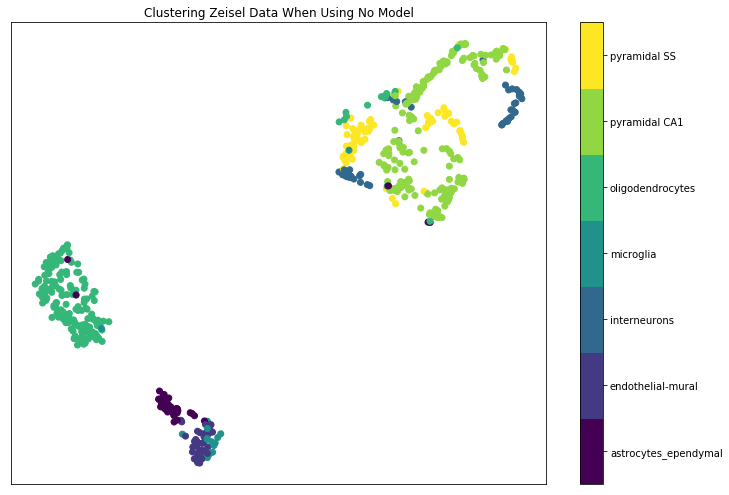

In [38]:
graph_zeisel(test_data.cpu().numpy(), test_labels, "No", zeisel_encoder)

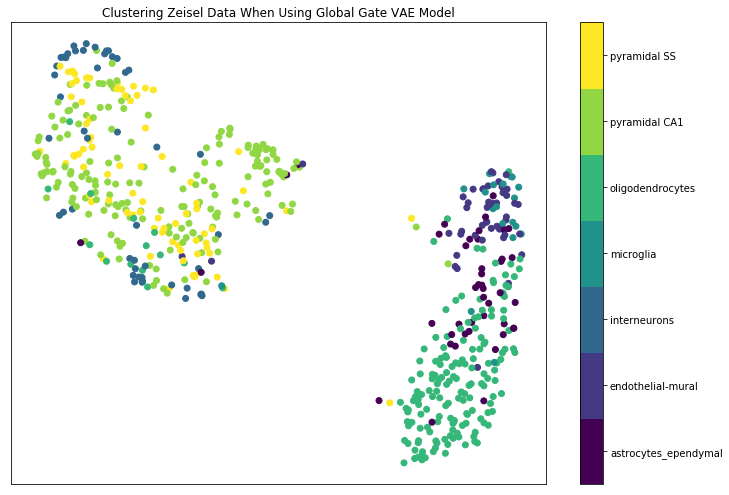

In [39]:
graph_zeisel(test_data[:, inds_global_gate].cpu().numpy(), test_labels, "Global Gate VAE", zeisel_encoder)

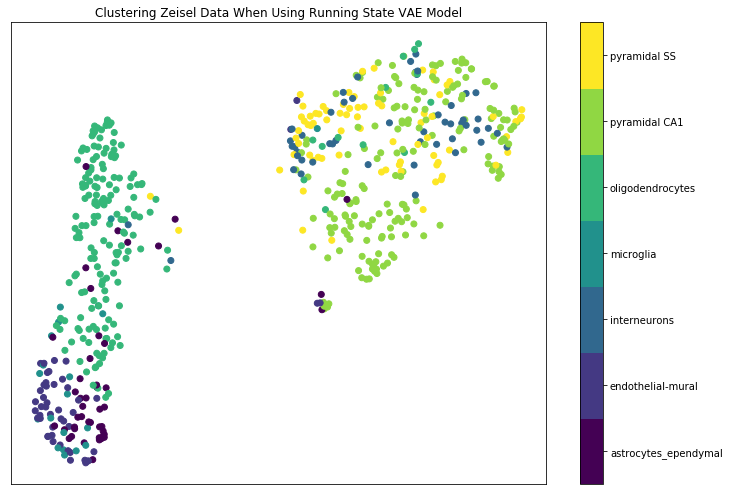

In [40]:
graph_zeisel(test_data[:, inds_running_state].cpu().numpy(), test_labels, "Running State VAE", zeisel_encoder)

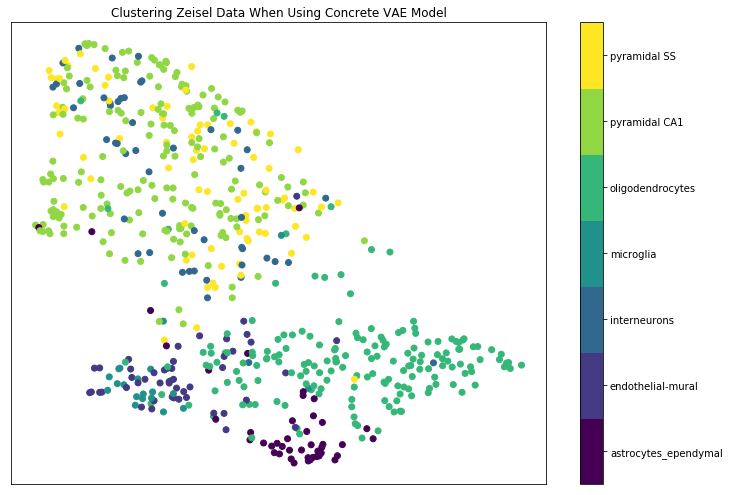

In [41]:
graph_zeisel(test_data[:, inds_concrete_vae].cpu().numpy(), test_labels, "Concrete VAE", zeisel_encoder)